In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn
import xgboost as xgb
import seaborn as sns

In [ ]:
# load the dataset
strokeData = pd.read_csv('necessaryfiles/healthcare-dataset-stroke-data.csv')
# Display the first few rows of the dataset and the dimensions of the matrix
print(strokeData.head())
shape = strokeData.shape
print(f"Shape: {shape}")

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
Shape: (5110, 12)


Data Preprocessing (Delete missing values, check for duplicates, transform data points from categorical to numerical if necessary, etc.)

In [7]:
strokeData = strokeData.dropna() # Remove rows with missing values
numDuplicates = strokeData.duplicated().sum() # Count duplicate rows
print(numDuplicates) 

0


In [8]:
# transform categorical variables into numerical variables
strokeData['gender'] = strokeData['gender'].replace({'Male': 0, 'Female': 1, 'Other': 2})
strokeData['ever_married'] = strokeData['ever_married'].replace({'No': 0, 'Yes': 1})
strokeData['work_type'] = strokeData['work_type'].replace({'Private': 0, 'Self-employed': 1, 'children': 2, 'Govt_job': 3, 'Never_worked': 4})
strokeData['Residence_type'] = strokeData['Residence_type'].replace({'Urban': 1, 'Rural': 0})
strokeData['smoking_status'] = strokeData['smoking_status'].replace({'never smoked' : 1, 'formerly smoked': 0, 'smokes': 2, 'Unknown': 3})

# Index with patient_id
strokeData = strokeData.set_index('id')

/var/folders/dx/qdwnsv1j11365fsy3vnb86f80000gn/T/ipykernel_3555/3556266186.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  strokeData['gender'] = strokeData['gender'].replace({'Male': 0, 'Female': 1, 'Other': 2})
/var/folders/dx/qdwnsv1j11365fsy3vnb86f80000gn/T/ipykernel_3555/3556266186.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  strokeData['ever_married'] = strokeData['ever_married'].replace({'No': 0, 'Yes': 1})
/var/folders/dx/qdwnsv1j11365fsy3vnb86f80000gn/T/ipykernel_3555/3556266186.py:4: FutureWarning: Downcasting

Summary Statistics and Visualization of Data Prior to Scaling

In [9]:
# Display statistical summary of the dataset
summary = strokeData.describe()
print(summary)

# Calculate and display the median values for each column
medianValues = strokeData.median()
# print(medianValues)

# Calculate and display the mode values for each column
modeValues = strokeData.mode()
# print(modeValues)

            gender          age  hypertension  heart_disease  ever_married  \
count  4909.000000  4909.000000   4909.000000    4909.000000   4909.000000   
mean      0.590548    42.865374      0.091872       0.049501      0.652679   
std       0.492197    22.555115      0.288875       0.216934      0.476167   
min       0.000000     0.080000      0.000000       0.000000      0.000000   
25%       0.000000    25.000000      0.000000       0.000000      0.000000   
50%       1.000000    44.000000      0.000000       0.000000      1.000000   
75%       1.000000    60.000000      0.000000       0.000000      1.000000   
max       2.000000    82.000000      1.000000       1.000000      1.000000   

         work_type  Residence_type  avg_glucose_level          bmi  \
count  4909.000000     4909.000000        4909.000000  4909.000000   
mean      0.834182        0.507232         105.305150    28.893237   
std       1.111640        0.499999          44.424341     7.854067   
min       0.00000

In [10]:
# Comparing the Dependent Variable with other features
# Number of stroke compared to not stroke

countStroke = strokeData['stroke'].value_counts()
print(f"Number of people who had a stroke: {countStroke[1]}\nNumber of people who did NOT have a stroke: {countStroke[0]}")

Number of people who had a stroke: 209
Number of people who did NOT have a stroke: 4700


In [11]:
strokeData.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3852
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

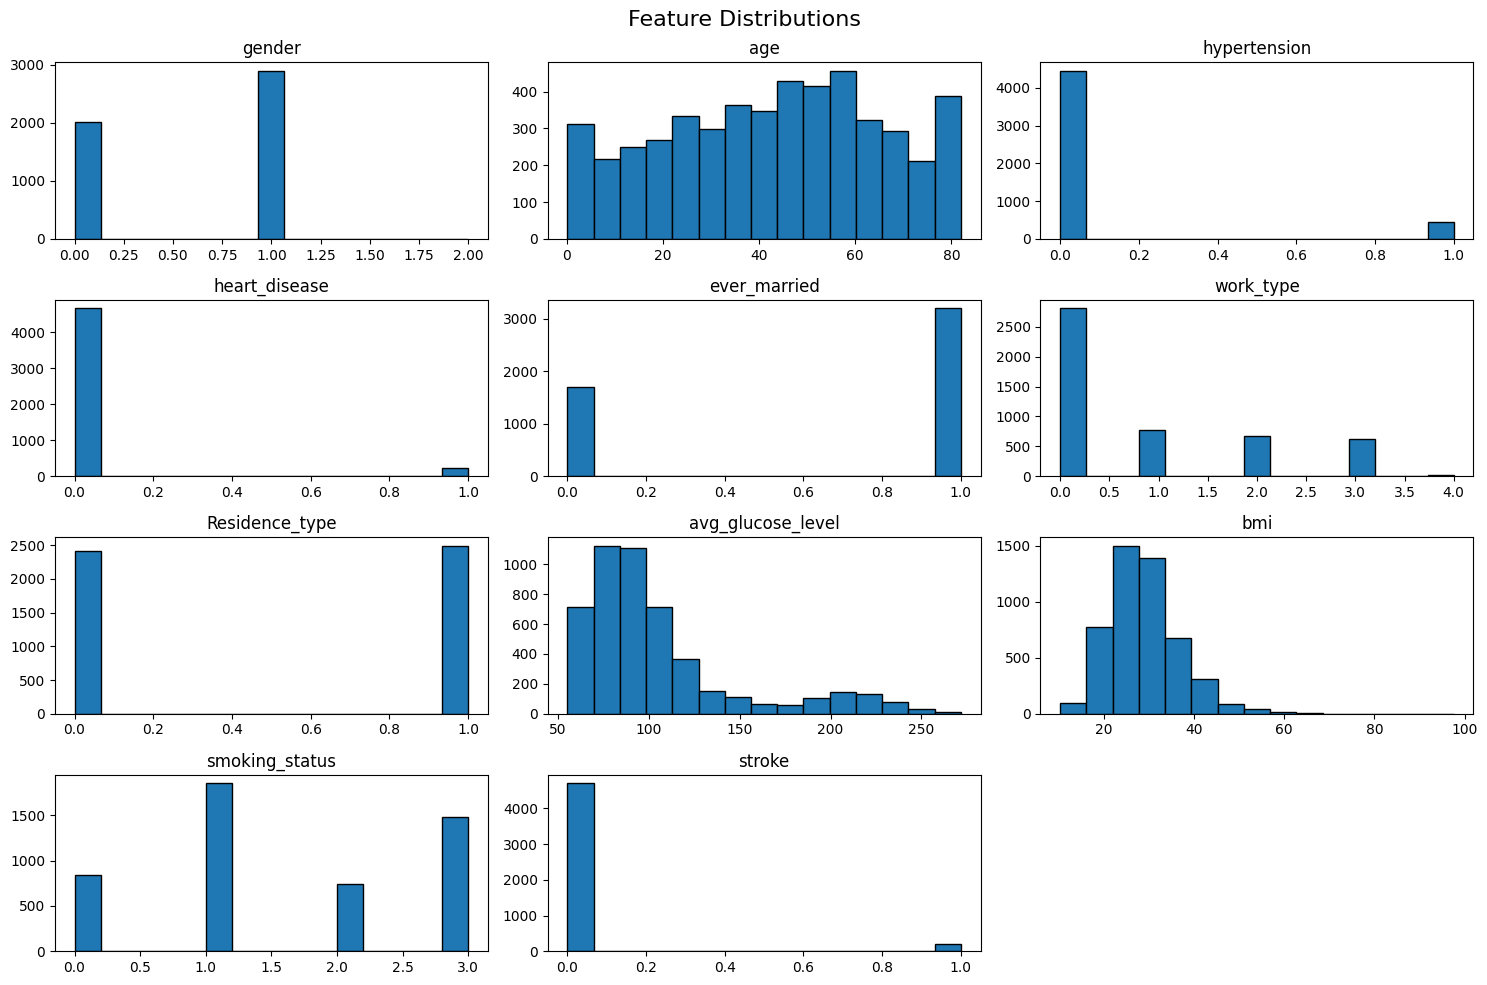

In [12]:
axes = strokeData.hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)

for ax in axes.flatten():
    ax.grid(False)

plt.tight_layout()
plt.show()

In [13]:
# Show the mean values for when a person has had a stroke vs when they have not
strokeData.groupby('stroke').mean()

# Results indicate that age, hypertension, heart disease and avg_glucose_level change a lot

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
stroke,,,,,,,,,,
0,0.591277,41.760451,0.083191,0.043191,0.642128,0.841702,0.506596,104.003736,28.823064,1.601277
1,0.574163,67.712919,0.287081,0.191388,0.889952,0.665072,0.521531,134.571388,30.471292,1.191388


In [14]:
correlationMatrix = strokeData.corr()
print(correlationMatrix['stroke'].sort_values(ascending=False))

stroke               1.000000
age                  0.232331
hypertension         0.142515
avg_glucose_level    0.138936
heart_disease        0.137938
ever_married         0.105089
bmi                  0.042374
Residence_type       0.006031
gender              -0.007021
work_type           -0.032083
smoking_status      -0.075920
Name: stroke, dtype: float64


In [15]:
# sns.heatmap(correlationMatrix, annot=True, fmt=".2f", cmap='coolwarm')
# plt.title('Correlation Matrix Heatmap')
# plt.show()

# Heatmap does not add much value

Separate Dependent Variable

Split into Test and Train Sets

Feature Selection

In [16]:
X = strokeData.drop(columns=['stroke'])
y = strokeData['stroke']

print(X.shape)
print(y.shape)

(4909, 10)
(4909,)


In [17]:
# Need to convert to numpy arrays for model input
X = np.array(X)
y = np.array(y)

In [18]:
# 20% test size, 80% train size
from sklearn.model_selection import train_test_split
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=3)

In [19]:
# STANDARDIZE the Data

# Fns to compute mean and st.dev
def computeMeanStd(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0, ddof = 1)
    return mean, std

def standardize(X, mean, std):
    XStd = (X - mean) / std
    return XStd   

# compute mean and st.dev for the training set
meanTrain, stdTrain = computeMeanStd(XTrain)

# standardize both training and test sets
XTrainScaled = standardize(XTrain, meanTrain, stdTrain)
XTestScaled = standardize(XTest, meanTrain, stdTrain)

Feature Selection (try L1-norm Regularization, significance level, PCA)

In [20]:
from sklearn.linear_model import Lasso

# Lasso Regression Model
alpha = 0.01 # Higher alpha means more SPARSITY
lasso = Lasso(alpha=alpha)

# Fit the Lasso model to the standardized training data
lasso.fit(XTrainScaled, yTrain)

print("Coefficients of the Lasso Regression Model:", lasso.coef_)

# Below implies that Age, Hypertension, Heart Disease, and Average Glucose Level are the most important features for predicting a stroke
# Which also implies that gender, work type, residence type, and smoking status are less important features for predicting a stroke

Coefficients of the Lasso Regression Model: [-0.          0.03247814  0.00801594  0.01138953 -0.          0.
  0.          0.00359201 -0.         -0.        ]


Order of Most Important (l1 Regularizer): Age, Heart Disease, Hypertension, Average Glucose Level.

In [21]:
from sklearn.linear_model import Lasso

# Lasso Regression Model AGAIN with HIGHER ALPHA
alpha = 0.001 # Higher alpha means more SPARSITY
lasso = Lasso(alpha=alpha)

# Fit the Lasso model to the standardized training data
lasso.fit(XTrainScaled, yTrain)

print("Coefficients of the Lasso Regression Model:", lasso.coef_)

# Below implies that Gender, Work Type, and Smoking Status are the least important features for predicting a stroke

Coefficients of the Lasso Regression Model: [ 0.          0.05143458  0.01418738  0.01591017 -0.01738027  0.
  0.00090859  0.00997067 -0.00765962  0.        ]


Principal Component Analysis

In [22]:
covarianceMatrix = np.cov(XTrainScaled, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(covarianceMatrix)

loadingFactors = eigenvectors * np.sqrt(eigenvalues)
print("Loading Factors of the PCA Model:", loadingFactors)

# Rows are features, columns are principal components

Loading Factors of the PCA Model: [[ 0.05036874  0.01315213 -0.56708763 -0.19477947 -0.02822877 -0.62249581
   0.31529797  0.38241147 -0.05469191  0.02867301]
 [ 0.84503349 -0.39701639 -0.00354195 -0.0267148   0.21864176  0.02034233
   0.2185687  -0.14182113  0.00705383  0.10684977]
 [ 0.43849827  0.05453904  0.32465762 -0.16848454  0.08904991 -0.32362329
  -0.38783197 -0.02030449 -0.63805266  0.01887122]
 [ 0.32229653  0.07364559  0.56084191  0.12855032 -0.30559178  0.1307564
   0.5612451   0.3136368  -0.16687352  0.08909543]
 [ 0.76920665  0.3359391  -0.16925367 -0.01940668  0.289708    0.07287831
   0.17115711 -0.25802772  0.13340244  0.25205433]
 [-0.33636876 -0.01079166  0.37699632 -0.31484391 -0.18170881 -0.46011637
   0.19967355 -0.55779248  0.19652665  0.10553116]
 [ 0.02105903  0.00620699 -0.01118031 -0.91090319 -0.01291874  0.38064501
   0.02214065  0.14440727  0.00853155 -0.0563418 ]
 [ 0.39937571  0.02966412  0.47295735 -0.03985128  0.18906472 -0.27358697
  -0.22587337  0.3

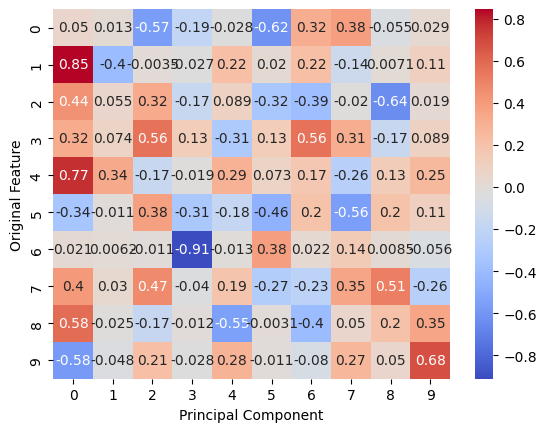

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(loadingFactors, annot=True, cmap='coolwarm')
plt.xlabel("Principal Component")
plt.ylabel("Original Feature")
plt.show()

PC1: Accounts for the Most Variance
    Age, Ever Married, BMI are most positively correlated in this component
    Work Type and Smoking Status are the most negatively correlated here

PC4: Also interesting because it goes all in on Glucose Level

Logistic Regression Hypothesis Testing with p-Values

In [24]:
import statsmodels.api as sm

# Add intercept to XTrainScaled for stats models
XTrainScaledWithIntercept = sm.add_constant(XTrainScaled)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(yTrain, XTrainScaledWithIntercept)
result = logit_model.fit(disp=False)

# Get p-values and coefficients
p_values = result.pvalues
coefficients = result.params

for i in range(len(p_values)):
    if p_values[i] < 0.05:
        print(f"Feature {i} is statistically significant with a p-value of {p_values[i]}")



Feature 0 is statistically significant with a p-value of 3.1512480381501363e-130
Feature 2 is statistically significant with a p-value of 1.266996956607034e-28
Feature 3 is statistically significant with a p-value of 0.006864495374607509
Feature 4 is statistically significant with a p-value of 0.016552871294251596
Feature 8 is statistically significant with a p-value of 0.03205877043336202


Logistic Regression hypothesis testing indicates age, hpertension, average glucose are the only significant features (feature 0 is the intercept coefficient)

Chi-Squared Test for Categorical Variables

In [25]:
from scipy.stats import chi2_contingency

# Select the categorical features
categoricalFeatures = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

XTrainScaledDf = pd.DataFrame(XTrainScaled, columns = strokeData.drop(columns=['stroke']).columns)
yTrainDf = pd.DataFrame(yTrain, columns=['stroke'])

# Chi-Squared Test for each categorical feature
for feature in categoricalFeatures:
    # Create a contingency table
    contingencyTable = pd.crosstab(XTrainScaledDf[feature], yTrainDf['stroke'])
    
    # Perform the Chi-Squared test
    chi2, p, dof, expected = chi2_contingency(contingencyTable)
    
    # Print the results
    print(f"Chi-Squared Test for {feature}: p-value {p}")
    if p < 0.05:
        print(f"{feature} is statistically significant")
    else:
        print(f"{feature} is not statistically significant")

Chi-Squared Test for gender: p-value 0.9719251468213815
gender is not statistically significant
Chi-Squared Test for ever_married: p-value 1.8922193502132535e-09
ever_married is statistically significant
Chi-Squared Test for work_type: p-value 1.8632695967467473e-06
work_type is statistically significant
Chi-Squared Test for Residence_type: p-value 0.4362850348032289
Residence_type is not statistically significant
Chi-Squared Test for smoking_status: p-value 1.076171600934509e-06
smoking_status is statistically significant


Chi-Squared gives hypertension, heart disease, ever married, work type, and smoking status as significant features.

When looking at all the methods it seems like gender and bmi are the least significant. But since p is low compared to N, we should be able to keep all the features at first. Then, if we want, we can compare our evaluation metrics to a model if we were to just keep age, hypertension, heart disease, and avg glucose levels (as these were the most important features determined by the l-1 regularizer)

In [26]:
# Reduce the dataset to only include significant features
XTrainScaledReduced = XTrainScaledDf[['age', 'hypertension', 'heart_disease', 'avg_glucose_level']]
XTestScaledDf = pd.DataFrame(XTestScaled, columns=strokeData.drop(columns=['stroke']).columns)
XTestScaledReduced = XTestScaledDf[['age', 'hypertension', 'heart_disease', 'avg_glucose_level']]

MODEL IMPLEMENTATION (XGBoost, KNN, SVM (Linear, Polynomial, Radial Kernel))

XGB Accuracy: 0.5234
XGB Precision: 0.0701
XGB Recall: 0.8974
XGB F1 Score: 0.1301
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.51      0.67       943
           1       0.07      0.90      0.13        39

    accuracy                           0.52       982
   macro avg       0.53      0.70      0.40       982
weighted avg       0.96      0.52      0.65       982



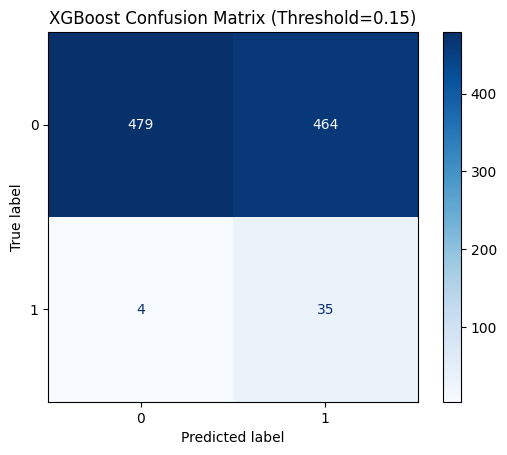

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

xgb = XGBClassifier(
    eval_metric='logloss', 
    scale_pos_weight=100, # Increased for imbalance between stroke and no stroke
    max_depth=6, # Deeper trees to capture complex patterns
    learning_rate=0.01, # Slower learning rate for better convergence
    n_estimators=400, # More trees for better performance
    subsample=0.9 
)

xgb.fit(XTrainScaled, yTrain)

yPredProba = xgb.predict_proba(XTestScaled)[:, 1]

yPred = (yPredProba >= 0.1).astype(int) # We want to flag for a doc even if there is a 10% chance of a stroke

xgbAccuracy = sklearn.metrics.accuracy_score(yTest, yPred)
xgbPrecision = sklearn.metrics.precision_score(yTest, yPred)
xgbRecall = sklearn.metrics.recall_score(yTest, yPred)
xgbF1 = sklearn.metrics.f1_score(yTest, yPred)


print(f"XGB Accuracy: {xgbAccuracy:.4f}")
print(f"XGB Precision: {xgbPrecision:.4f}")
print(f"XGB Recall: {xgbRecall:.4f}")
print(f"XGB F1 Score: {xgbF1:.4f}")


print("XGBoost Classification Report:")
print(classification_report(yTest, yPred))

xgbCm = confusion_matrix(yTest, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=xgbCm, display_labels=xgb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix (Threshold=0.15)')
plt.show()


We achieve a good recall and a low number of false negatives. Even though it looks funny, we'd rather have a lot of false positives in the model as to ensure patients see the doctor just in case.

In [43]:
from sklearn.model_selection import KFold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

xgbAccuracys = []
xgbPrecisions = []
xgbRecalls = []
xgbF1s = []

threshold = 0.15

# k-Fold Cross-Validation
for trainIndex, testIndex in kf.split(XTrainScaled):

    XTrainFold, XTestFold = XTrainScaled[trainIndex], XTrainScaled[testIndex]
    yTrainFold, yTestFold = yTrain[trainIndex], yTrain[testIndex]
    
    xgb.fit(XTrainFold, yTrainFold)
    
    yPredProbaFold = xgb.predict_proba(XTestFold)[:, 1]
    yPredFold = (yPredProbaFold >= threshold).astype(int)
    
    xgbAccuracys.append(sklearn.metrics.accuracy_score(yTestFold, yPredFold))
    xgbPrecisions.append(sklearn.metrics.precision_score(yTestFold, yPredFold))
    xgbRecalls.append(sklearn.metrics.recall_score(yTestFold, yPredFold))
    xgbF1s.append(sklearn.metrics.f1_score(yTestFold, yPredFold))

print(f"XGB {k}-Fold CV AVERAGE Accuracy: {np.mean(xgbAccuracys):.4f}")
print(f"XGB {k}-Fold CV AVERAGE Precision: {np.mean(xgbPrecisions):.4f}")
print(f"XGB {k}-Fold CV AVERAGE Recall: {np.mean(xgbRecalls):.4f}")
print(f"XGB {k}-Fold CV AVERAGE F1 Score: {np.mean(xgbF1s):.4f}")

XGB 5-Fold CV AVERAGE Accuracy: 0.5694
XGB 5-Fold CV AVERAGE Precision: 0.0843
XGB 5-Fold CV AVERAGE Recall: 0.9017
XGB 5-Fold CV AVERAGE F1 Score: 0.1537


Lets try with the most important features

XGB Accuracy: 0.4807
XGB Precision: 0.0679
XGB Recall: 0.9487
XGB F1 Score: 0.1267
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.46      0.63       943
           1       0.07      0.95      0.13        39

    accuracy                           0.48       982
   macro avg       0.53      0.71      0.38       982
weighted avg       0.96      0.48      0.61       982



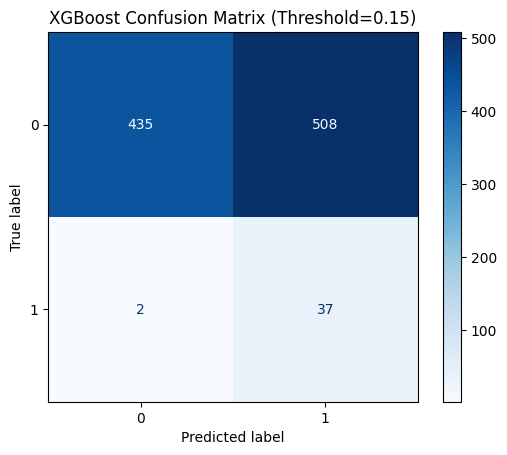

In [44]:
xgb = XGBClassifier(
    eval_metric='logloss', 
    scale_pos_weight=100, # Increased for imbalance between stroke and no stroke
    max_depth=6, # Deeper trees to capture complex patterns
    learning_rate=0.01, # Slower learning rate for better convergence
    n_estimators=400, # More trees for better performance
    subsample=0.9 
)

xgb.fit(XTrainScaledReduced, yTrain)

yPredProbaReduced = xgb.predict_proba(XTestScaledReduced)[:, 1]

yPredReduced = (yPredProbaReduced >= 0.1).astype(int) # We want to flag for a doc even if there is a 10% chance of a stroke

xgbAccuracy = sklearn.metrics.accuracy_score(yTest, yPredReduced)
xgbPrecision = sklearn.metrics.precision_score(yTest, yPredReduced)
xgbRecall = sklearn.metrics.recall_score(yTest, yPredReduced)
xgbF1 = sklearn.metrics.f1_score(yTest, yPredReduced)

print(f"XGB Accuracy: {xgbAccuracy:.4f}")
print(f"XGB Precision: {xgbPrecision:.4f}")
print(f"XGB Recall: {xgbRecall:.4f}")
print(f"XGB F1 Score: {xgbF1:.4f}")


print("XGBoost Classification Report:")
print(classification_report(yTest, yPredReduced))

xgbCm = confusion_matrix(yTest, yPredReduced)
disp = ConfusionMatrixDisplay(confusion_matrix=xgbCm, display_labels=xgb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix (Threshold=0.15)')
plt.show()
